# HW10_Assignment2_zn352 - Spatial Data Analysis (Seasonal)
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

## Import initial libraries

In [229]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from pandas import DataFrame
import matplotlib.pylab as plt
plt.style.use('ggplot')

## Working with Shape File

### Loading Census Tract Shape File¶

In [230]:
from geopandas import GeoDataFrame
shape_path = "Data/ct_shape.shp"  #I store the file in 'Data' folder
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [231]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
# incase the file does not have a coordinate system 

NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

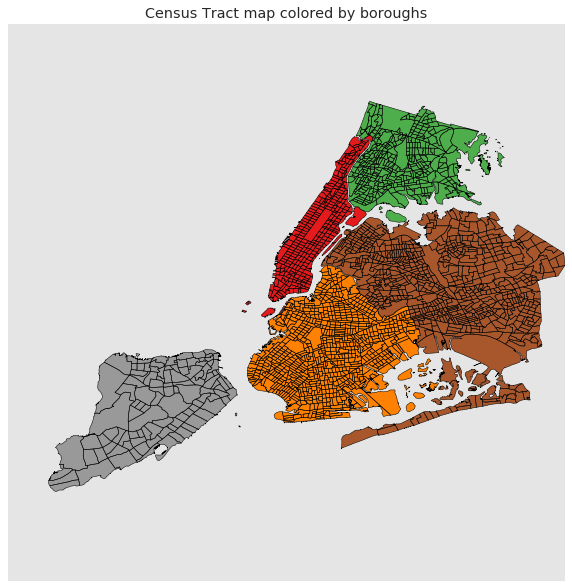

In [232]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

Figure 1 - NYC Census Tract Map by Borough

### Map NYC Population density

#### Load Census Data for 2010

In [233]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [234]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

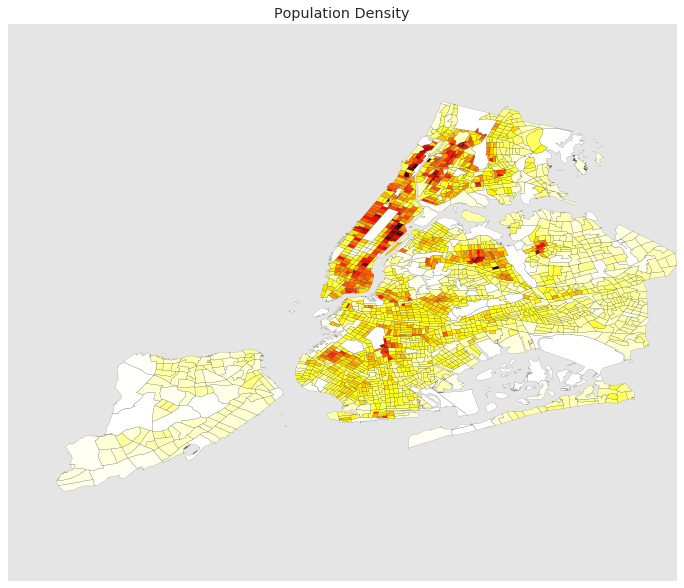

In [235]:
f, ax = plt.subplots(figsize=(12,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

Figure 2 - Population Density Map in NYC

## Explore CitiBike data

### Load CitiBike data

In [236]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

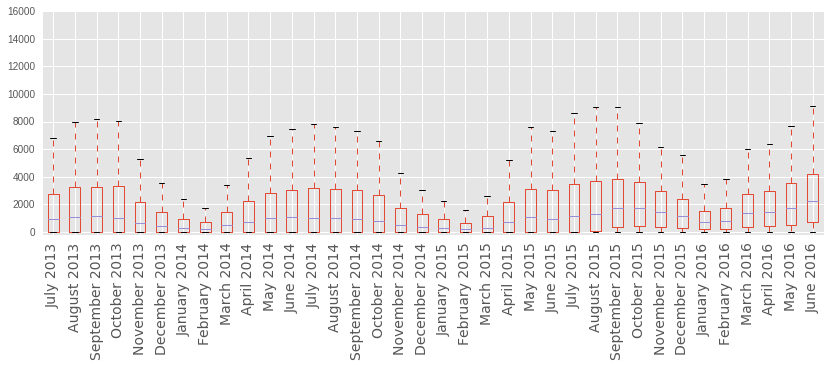

In [237]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

Figure 3 - Map of Citi Bike Monthly Usage

#### Seasonal Decomposition

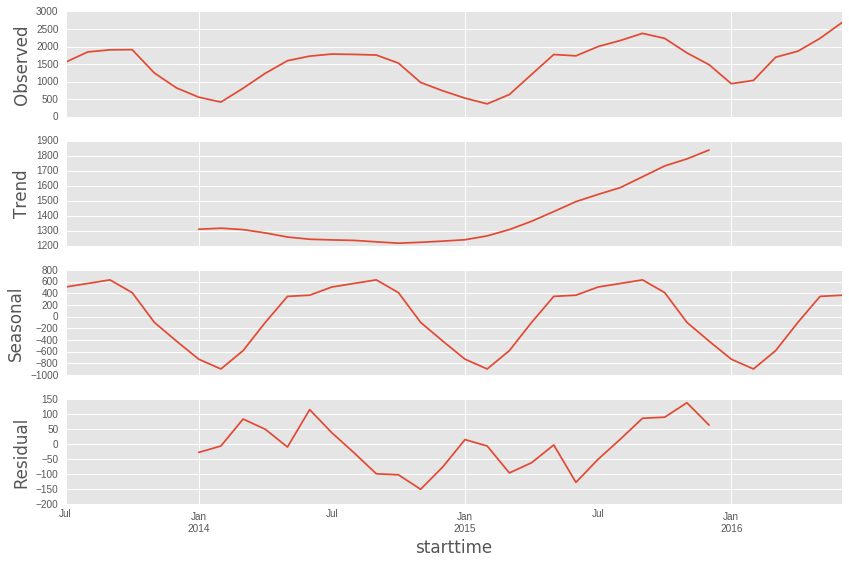

In [238]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

Figure 4 - Time Series Analysis of Monthly Citi Bike Usage, with Seasonal and Trend Decomposition.

### From Figure 3 and Figure 4 we observe a significant periodicity between seasons. Summer time (start from July to September) often has the highest peak in usage, while winter/spring (start from Jan to March) has the lowest usage of Citi Bike. 
### I will analysis average summer usage from July to September of year 2013 to 2015, and winter usage from January to March of year 2014 to 2016

### Sum up seasonal data

In [239]:
pd.to_datetime(df_bike_monthly.index)

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31', '2014-09-30', '2014-10-31',
               '2014-11-30', '2014-12-31', '2015-01-31', '2015-02-28',
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31', '2016-01-31', '2016-02-29',
               '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30'],
              dtype='datetime64[ns]', name=u'starttime', freq=None)

In [240]:
TS = df_bike_monthly.index.to_period('Q-DEC') #set quarterly time series start from 2013-Jul

In [241]:
TS

PeriodIndex(['2013Q3', '2013Q3', '2013Q3', '2013Q4', '2013Q4', '2013Q4',
             '2014Q1', '2014Q1', '2014Q1', '2014Q2', '2014Q2', '2014Q2',
             '2014Q3', '2014Q3', '2014Q3', '2014Q4', '2014Q4', '2014Q4',
             '2015Q1', '2015Q1', '2015Q1', '2015Q2', '2015Q2', '2015Q2',
             '2015Q3', '2015Q3', '2015Q3', '2015Q4', '2015Q4', '2015Q4',
             '2016Q1', '2016Q1', '2016Q1', '2016Q2', '2016Q2', '2016Q2'],
            dtype='int64', name=u'starttime', freq='Q-DEC')

In [242]:
df_bike_seasonal = df_bike_monthly.groupby(TS).sum()

In [243]:
df_bike_seasonal.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013Q3,7917,13601,25813,9922,19396,8203,7691,10151,12511,8163,...,0,0,0,0,0,0,0,0,0,0
2013Q4,6102,8790,20921,7652,17175,6897,4775,8526,9363,5090,...,0,0,0,0,0,0,0,0,0,0
2014Q1,2410,3856,11200,3368,6371,3540,1834,4461,4150,2091,...,0,0,0,0,0,0,0,0,0,0
2014Q2,5063,8746,25752,9001,17941,8105,5383,10569,10557,6024,...,0,0,0,0,0,0,0,0,0,0
2014Q3,6712,9898,30378,10762,22082,10230,6625,11922,11557,6751,...,0,0,0,0,0,0,0,0,0,0


In [244]:
df_bike_seasonal.index

PeriodIndex(['2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
             '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2'],
            dtype='int64', name=u'starttime', freq='Q-DEC')


### Summer Data: 2013Q3, 2014Q3, 2015Q3.
### Winter Data: 2014Q1, 2015Q1, 2016Q1. 

## Summer

In [245]:
# create a new dataframe for winter data
df_bike_summer = df_bike_seasonal[df_bike_seasonal.index=='2013Q3']

In [246]:
# append dataframe for each row
df_bike_summer = df_bike_summer.append(df_bike_seasonal[df_bike_seasonal.index=='2014Q3'])

In [247]:
df_bike_summer = df_bike_summer.append(df_bike_seasonal[df_bike_seasonal.index=='2015Q3'])

In [248]:
df_bike_summer

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013Q3,7917,13601,25813,9922,19396,8203,7691,10151,12511,8163,...,0,0,0,0,0,0,0,0,0,0
2014Q3,6712,9898,30378,10762,22082,10230,6625,11922,11557,6751,...,0,0,0,0,0,0,0,0,0,0
2015Q3,8311,11791,33433,12603,20737,17107,7303,18471,14490,8574,...,0,0,0,0,0,0,0,0,0,0


## Winter

In [249]:
# create a new dataframe for winter data
df_bike_winter = df_bike_seasonal[df_bike_seasonal.index=='2014Q1']

In [250]:
# append dataframe for each row
df_bike_winter = df_bike_winter.append(df_bike_seasonal[df_bike_seasonal.index=='2015Q1'])

In [251]:
df_bike_winter = df_bike_winter.append(df_bike_seasonal[df_bike_seasonal.index=='2016Q1'])

In [252]:
df_bike_winter

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2014Q1,2410,3856,11200,3368,6371,3540,1834,4461,4150,2091,...,0,0,0,0,0,0,0,0,0,0
2015Q1,2407,0,8890,3562,5556,4616,1415,4389,3762,1835,...,0,0,0,0,0,0,0,0,0,0
2016Q1,4122,6801,17167,6464,9393,7859,3148,9314,0,3911,...,0,0,0,0,0,0,0,0,0,0


## Map CitiBike Data to CT level

### Load CitiBike station location data

In [253]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [254]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [255]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [195]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [256]:
### Create average winter rides column from winter citibike data and add it to the station id which has the geometry
station_id['SummerAve'] = df_bike_summer.mean()
station_id['WinterAve'] = df_bike_winter.mean()

In [257]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,SummerAve,WinterAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,7646.666667,2979.666667
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,11763.333333,3552.333333
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,29874.666667,12419.000000
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,11095.666667,4464.666667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,20738.333333,7106.666667


### Add the average rides to the CT shapefile 

In [270]:
temp_s =station_id[['SummerAve']]
temp_s['station_id'] = station_id.index
temp_s.index=station_id['BoroCT2010']
ct_shape_SummerAve=ct_shape.join(temp_s)
ct_shape_SummerAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


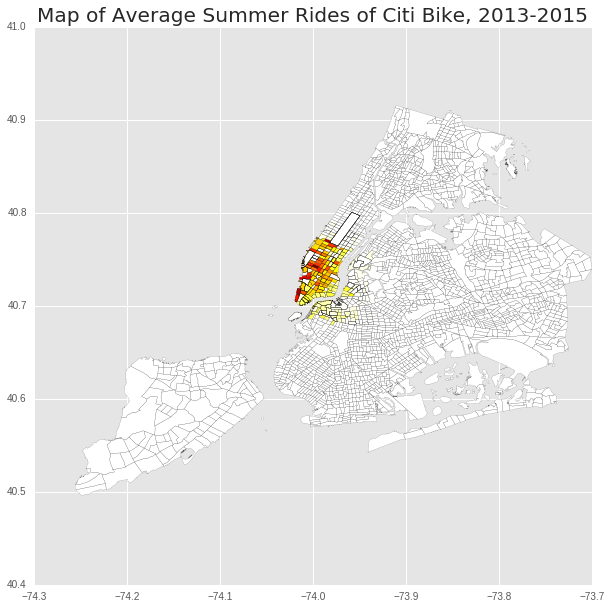

In [271]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_SummerAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Summer Rides of Citi Bike, 2013-2015')

Figure 5a - Average Citi Bike Ridership in Summer, NYC (2013-2015) 

In [273]:
temp_w = station_id[['WinterAve']]
temp_w['station_id'] = station_id.index
temp_w.index = station_id['BoroCT2010']
ct_shape_WinterAve = ct_shape.join(temp_w)
ct_shape_WinterAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


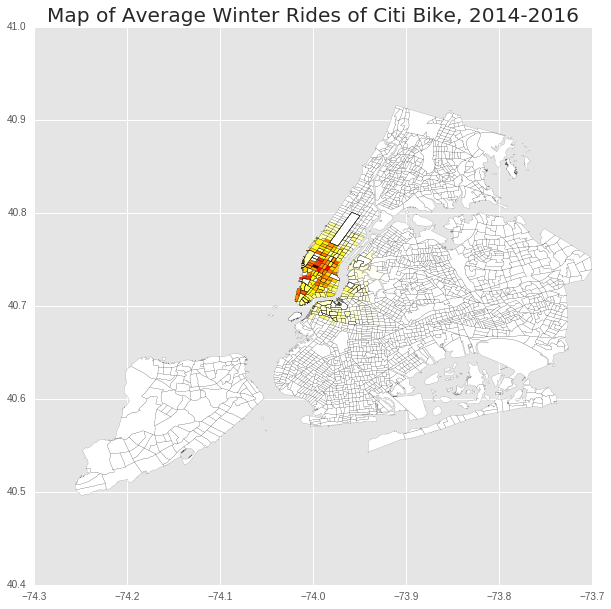

In [274]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Winter Rides of Citi Bike, 2014-2016')

Figure 5b - Average Citi Bike Ridership in Winter, NYC (2014-2016) 

### Removing the CTs that are out of zoom boundries

In [275]:
ct_shape_SummerAve_Zoom=(ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [277]:
print "Total number of CTs for Summer:", len(ct_shape)
print "Number of zoomed CTs for Summer:", len(temp_s.SummerAve)

 Total number of CTs for Summer: 2166
Number of zoomed CTs for Summer: 543


In [278]:
# zoom? 
ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [280]:
print "Total number of CTs for Winter:", len(ct_shape)
print "Number of zoomed CTs for Winter:", len(temp_w.WinterAve)

Total number of CTs for Winter: 2166
Number of zoomed CTs for Winter: 543


### Map the seasonal rides 

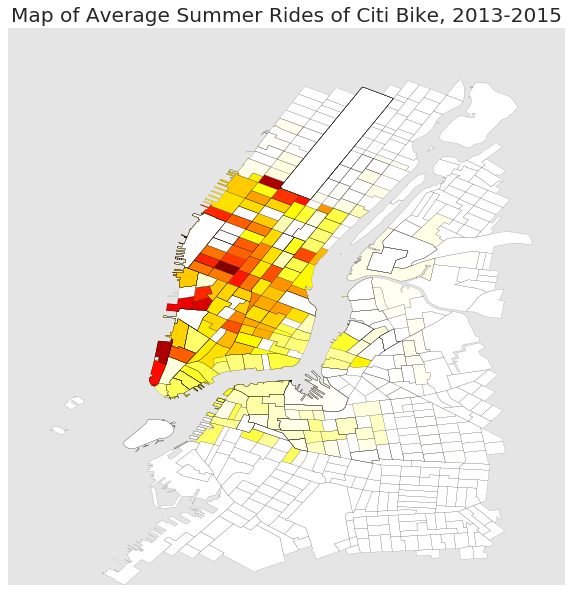

In [281]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Summer Rides of Citi Bike, 2013-2015')
plt.savefig('HW10_summerplot_zn352.png')

Figure 6a - Average Citi Bike Ridership in Summer, NYC (2013-2015)

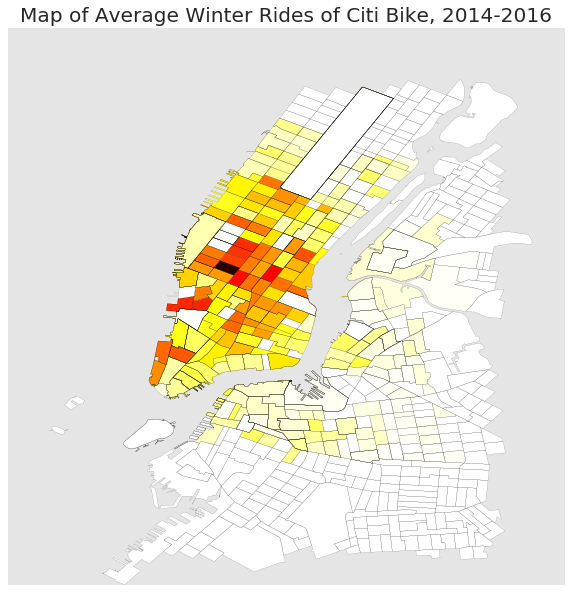

In [282]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title('Map of Average Winter Rides of Citi Bike, 2014-2016')
plt.savefig('HW10_winterplot_zn352.png')

Figure 6b - Average Citi Bike Ridership in Winter, NYC (2014-2016)

### Export Shapefile CTs in the CitiBike Zone

In [283]:
path = 'Data/ct_shape_SummerAve_Zoom2.shp'
ct_shape_SummerAve_Zoom.to_file(path)

In [284]:
path = 'Data/ct_shape_WinterAve_Zoom2.shp'
ct_shape_WinterAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [285]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [286]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [287]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [288]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [289]:
Wmatrix, ids = qW_CT.full()

In [290]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [291]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [292]:
SummerRide=ct_shape_SummerAve_Zoom.SummerAve
SummerRideLag=ps.lag_spatial(qW_CT, SummerRide)

In [293]:
WinterRide=ct_shape_WinterAve_Zoom.WinterAve
WinterRideLag=ps.lag_spatial(qW_CT, WinterRide)

#### Create Quantiles for maping

In [294]:
SummerRideLagQ10 = ps.Quantiles(SummerRideLag, k=10)
SummerRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               161
    0.000 < x[i] <=   232.220                78
  232.220 < x[i] <=   601.250                80
  601.250 < x[i] <=  1575.808                79
 1575.808 < x[i] <=  2815.911                80
 2815.911 < x[i] <=  6374.988                79
 6374.988 < x[i] <=  9346.381                80
 9346.381 < x[i] <= 10748.772                79
10748.772 < x[i] <= 16235.595                80

In [295]:
WinterRideLagQ10 = ps.Quantiles(WinterRideLag, k=10)
WinterRideLagQ10

                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=   13.095                 2
  13.095 < x[i] <=  214.486                78
 214.486 < x[i] <=  514.077                80
 514.077 < x[i] <=  807.752                79
 807.752 < x[i] <= 1160.861                80
1160.861 < x[i] <= 2599.008                79
2599.008 < x[i] <= 3552.913                80
3552.913 < x[i] <= 4277.033                79
4277.033 < x[i] <= 6987.000                80

#### Map the seasonal rides lag

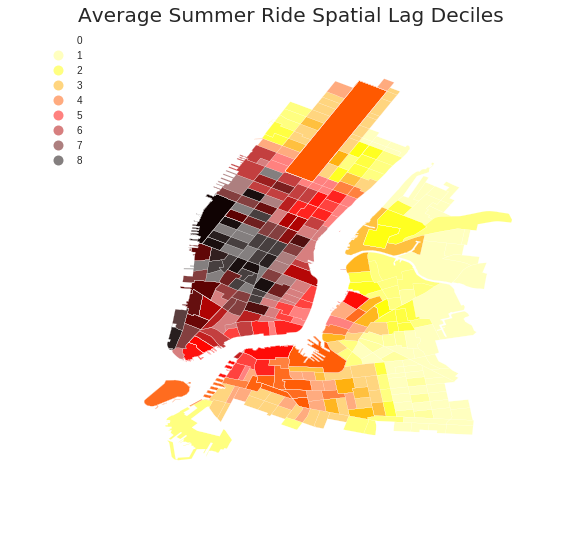

In [296]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_SummerAve_Zoom.assign(cl=SummerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Average Summer Ride Spatial Lag Deciles")
plt.savefig('HW10_summerlag_zn352.png')

Figure 7a - Spatial Lag Map by 10 Deciles, Average Citi Bike Ridership in Summer, NYC (2013-2015)

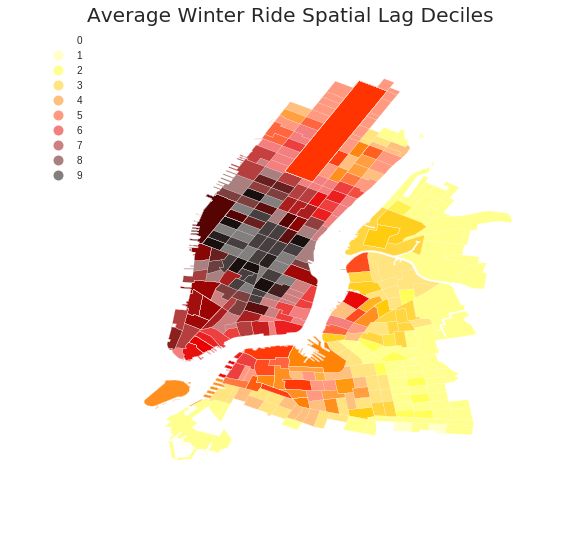

In [297]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_WinterAve_Zoom.assign(cl=WinterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Average Winter Ride Spatial Lag Deciles")
plt.savefig('HW10_winterlag_zn352.png')

Figure 7b - Spatial Lag Map by 10 Deciles, Average Citi Bike Ridership in Summer, NYC (2014-2016)

## Global  Spatial Autocorrelation

In [298]:
b,a = np.polyfit(SummerRide, SummerRideLag, 1)
b, a

(0.62926871704725484, 1443.0978573868299)

In [299]:
d,c = np.polyfit(WinterRide, WinterRideLag, 1)
d, c

(0.65936945695485016, 545.61613151533641)

### Moran Scatterplot

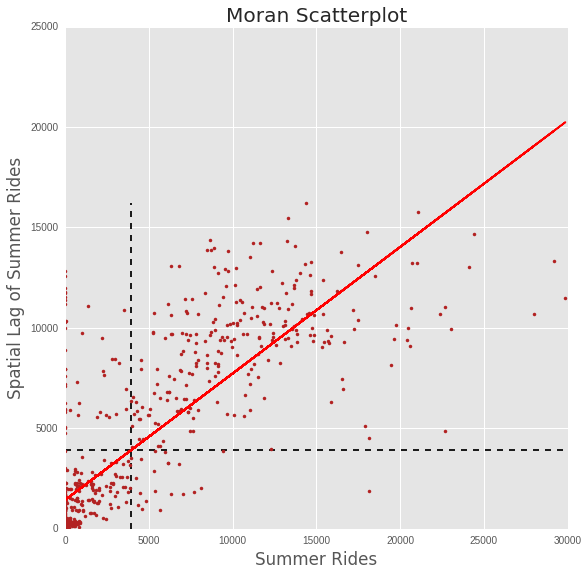

In [300]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SummerRide, SummerRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

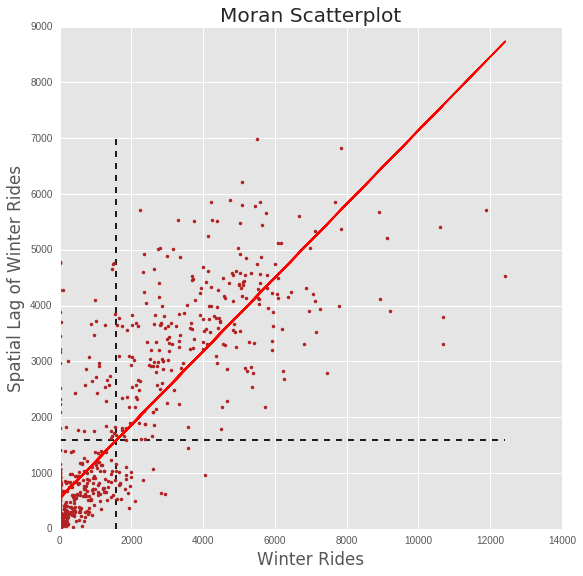

In [302]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(WinterRide, WinterRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, c + d*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

Figure 8a&b - Moran Scatterplot, Average Citi Bike Ridership in Summer and Winter, NYC (2013-2016)

Shows a positive correlation

### Moran's I

In [303]:
I_SummerRide = ps.Moran(SummerRide, qW_CT)
I_WinterRide = ps.Moran(WinterRide, qW_CT)

In [304]:
I_SummerRide.I, I_SummerRide.p_sim #sim - significant level, p value

(0.62946359212848402, 0.001)

In [305]:
I_WinterRide.I, I_WinterRide.p_sim 

(0.65951383017490961, 0.001)

Thus, the $I$ statistic is $0.629$ for summer and $0.659$ for winter, and has a very small $p$ value. 

In [306]:
I_SummerRide.sim[0:10]

array([ 0.02487702, -0.02005634, -0.00894344, -0.00088173, -0.00903365,
       -0.00947287, -0.02224283, -0.02020499, -0.02078959, -0.01234258])

In [307]:
I_WinterRide.sim[0:10]

array([-0.01714737,  0.00690484, -0.01295748,  0.02291943, -0.01551053,
       -0.0210731 , -0.01767221, -0.00333478, -0.01633318, -0.01927189])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [308]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

### Summer

(-0.7, 0.7)

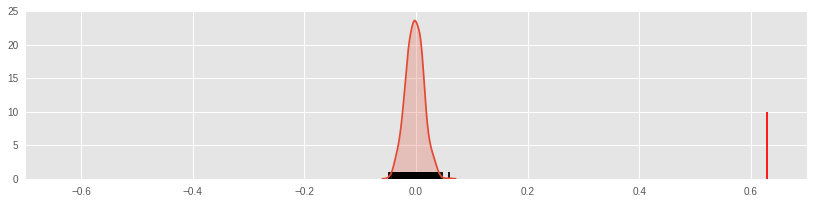

In [309]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

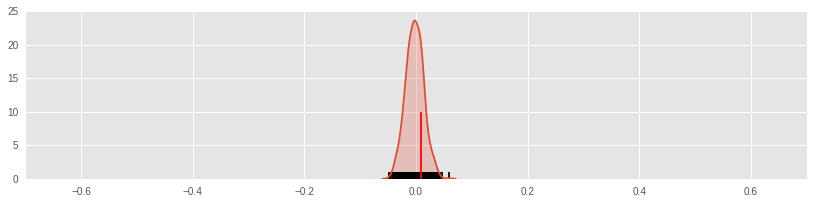

In [310]:
sns.kdeplot(I_SummerRide.sim, shade=True)
plt.vlines(I_SummerRide.sim, 0, 1)
plt.vlines(I_SummerRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Winter

(-0.7, 0.7)

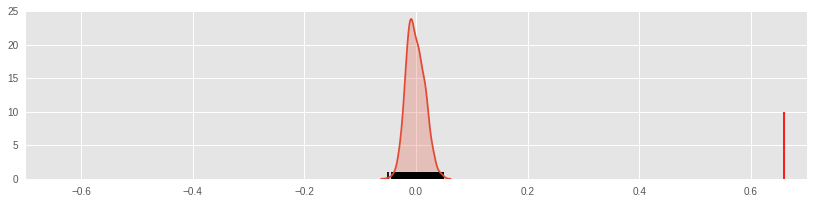

In [311]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

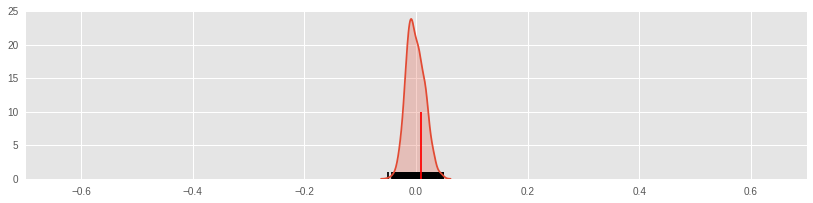

In [312]:
sns.kdeplot(I_WinterRide.sim, shade=True)
plt.vlines(I_WinterRide.sim, 0, 1)
plt.vlines(I_WinterRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [313]:
LMo_SummerRide = ps.Moran_Local(SummerRide, qW_CT, permutations=999)

In [315]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

(array([-0.        , -0.23326927,  0.01313014,  0.00869015,  0.0278383 ]),
 array([ 0.001,  0.197,  0.322,  0.331,  0.343]))

In [316]:
LMo_WinterRide = ps.Moran_Local(WinterRide, qW_CT, permutations=999)
# permutate 'my friends' from the 'poor' pool is called local permutatin instead of global per., return a correlation significance. 

In [317]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

(array([-0.        , -0.32301466, -0.00151236,  0.00049853, -0.05866435]),
 array([ 0.001,  0.141,  0.47 ,  0.461,  0.45 ]))

### LISA (Local Indicators of Spatial Autocorrelation) and plot

In [318]:
sigs = SummerRide[LMo_SummerRide.p_sim <= .001]
W_sigs = SummerRideLag[LMo_SummerRide.p_sim <= .001]
insigs = SummerRide[LMo_SummerRide.p_sim > .001]
W_insigs = SummerRideLag[LMo_SummerRide.p_sim > .001]

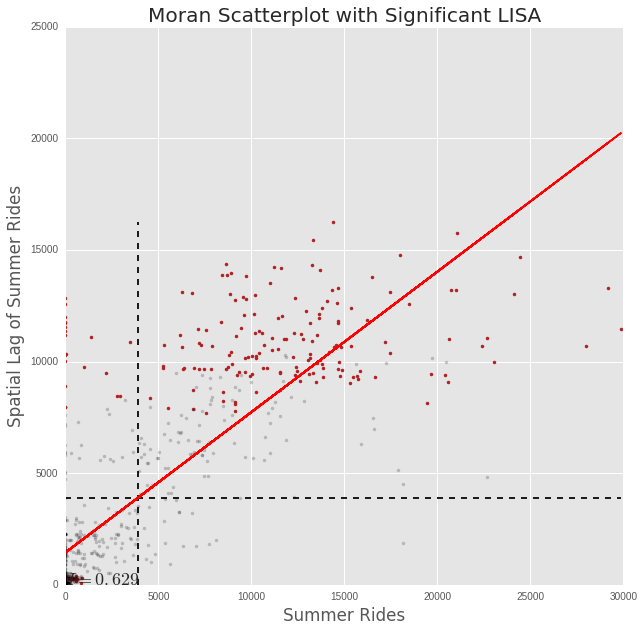

In [319]:
f, ax = plt.subplots(figsize=(10,10))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SummerRide.I, x=10, y=5, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SummerRide.mean(), SummerRideLag.min(), SummerRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SummerRideLag.mean(), SummerRide.min(), SummerRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SummerRide, a + b*SummerRide, 'r')
plt.title('Moran Scatterplot with Significant LISA')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

Figure 11

In [320]:
# find the significant results / insig re. 
sigs = WinterRide[LMo_WinterRide.p_sim <= .001]
W_sigs = WinterRideLag[LMo_WinterRide.p_sim <= .001]
insigs = WinterRide[LMo_WinterRide.p_sim > .001]
W_insigs = WinterRideLag[LMo_WinterRide.p_sim > .001]

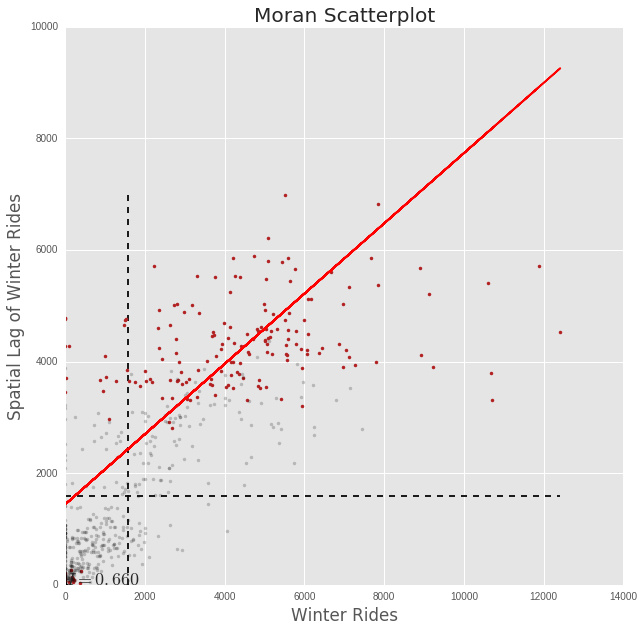

In [321]:
f, ax = plt.subplots(figsize=(10,10))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_WinterRide.I, x=10, y=5, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(WinterRide.mean(), WinterRideLag.min(), WinterRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(WinterRideLag.mean(), WinterRide.min(), WinterRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(WinterRide, a + b*WinterRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')


Figure 11

### Hot and Cold spots 

In [339]:
sig = LMo_SummerRide.p_sim < 0.01
hotspots = LMo_SummerRide.q==1 * sig
coldspots = LMo_SummerRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 188
Number of Coldspots: 213


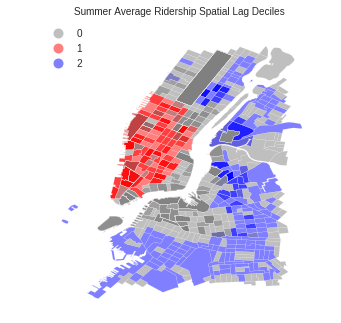

In [340]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(5,5))
ct_shape_SummerAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Summer Average Ridership Spatial Lag Deciles', fontsize=10)
plt.savefig('HW10_summer_zn352.png')

Figure 12a - Map of cold and hot spots, Average Citi Bike Ridership in Summer, NYC (2013-2015)

In [341]:
sig = LMo_WinterRide.p_sim < 0.01
hotspots = LMo_WinterRide.q==1 * sig
coldspots = LMo_WinterRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 198
Number of Coldspots: 246


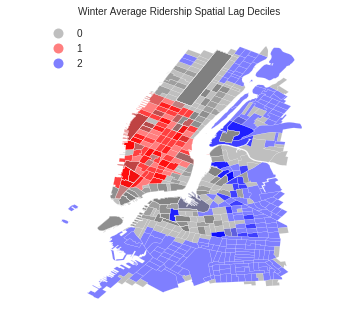

In [342]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(5, 5))
ct_shape_WinterAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Winter Average Ridership Spatial Lag Deciles', fontsize=10)
plt.savefig('HW10_winter_zn352.png')

Figure 12b - Map of cold and hot spots, Average Citi Bike Ridership in Winter, NYC (2014-2016)

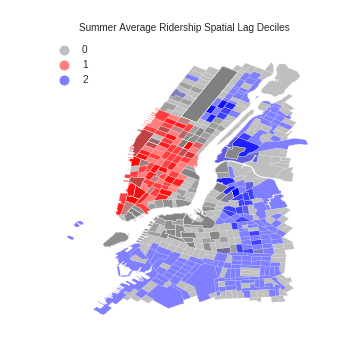

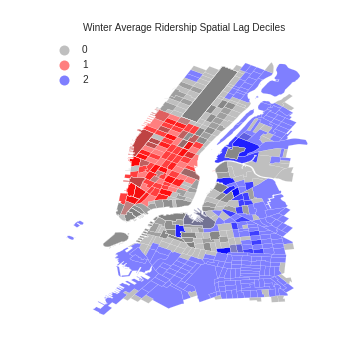

In [343]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='HW10_summer_zn352.png') 
y = Image(filename='HW10_winter_zn352.png') 
display(x, y)